# Assignment for Big Data Module 1

"*Implementare un interpolatore lineare a tratti su una griglia a $n$ dimensioni.*

*Supporre che sia data la struttura dati multidimensionale $S_{j_0, \cdots, j_{n - 1}}$ che contiene il valore del campione della funzione nel punto della griglia di indici $j_0, \cdots, j_{n-1}$ e che il punto in cui desidero calcolare l'interpolazione sia dato come un vettore $x_j$ con $n$ componenti.*"

Reference used: course lecture notes 4, *Interpolation*.

In [1]:
import numpy as np
np.random.seed(0)
from itertools import product # Cartesian product

Implementation of the convex decomposition of $\mathbf{x} \in [0, 1]^n$ into $n + 1$ pairs $(\mathbf{b}^j, \alpha_{\mathbf{b}^j})_{j = 0, \cdots, n}$, of:
*   selected vectors `b[j]` $= \mathbf{b}^j \in \mathbb{B}$, with $\mathbb{B} = \{0, 1\}^n$
*   corresponding coefficients `a[j]` $= {\alpha_{\mathbf{b}^j}} \ge 0$ s.t. ${\sum_{j = 0}^{n}} \alpha_{\mathbf{b}^j} = 1$.

In [2]:
def my_decomposition(x):
    
    n = len(x)          # dimension
    p = x.argsort()     # permutation that sorts x in ascending order
    B = np.concatenate( # B[j] will be the j-th element of the base
        (
            np.ones((n, n), dtype=bool),
            np.zeros((1, n), dtype=bool), # (last one is already known to be all 0s)
        )
    )
    a = np.zeros(n + 1) # alpha coefficients: a[j] is the coeff of B[j]
    
    # decomposition algorithm
    a[0] = x[p[0]]
    for j in range(1, n):
        B[j:, p[j - 1]] = 0 # entry j is zeroed from this vector on
        a[j] = x[p[j]] - x[p[j - 1]]
    a[n] = 1 - a.sum()

    '''
    # ~ n**2 / 2 flips
    # ~ n**2 / 4 flips
    n1 = (n + 1) // 2 + (n + 1) % 2
    n0 = (n + 1) // 2
    B = np.concatenate(
        (
            np.ones((n1, n), dtype=bool),  # 1st half (rounded up) all 1s
            np.zeros((n0, n), dtype=bool), # 2nd half (rounded down) all 0s
        ),
    )
    for i in range(1, n1):
        B[i:, p[i - 1]] = False
    for i in range(n1, n):
        B[n1:i+1, p[i]] = True
    '''

    return p, B, a

Check of the correctness of the implementation: it must hold that $\mathbf{x} = {\sum_{j = 0}^{n}} \alpha_{\mathbf{b}^j} \mathbf{b}^j$.

That is, `np.dot(a, B)` must amount to `x` up to the numerical precision.

In [3]:
n = np.random.randint(1, 1 + 5, (1,)).item() # random dimension (max 5)
x = np.random.rand(n)                        # random vector in [0, 1)^n

p, B, a = my_decomposition(x)

aB = np.dot(a, B)                            # recomposition
d = ((aB - x)**2).sum()**0.5                 # Euclidean distance

# print a summary of the test
print('\nVector')
print('n = %d' % n)
print('x =', x)
print('\nDecomposition')
print('p =', p)
print('B =')
print(B.astype(np.int))
print('a =', a)
print('\nCheck of the recomposition')
print('  x =', x)
print('a*B =', aB)
print('\nTheoretical discrepancy is 0. Numerical discrepancy: d =', d)


Vector
n = 5
x = [0.59284462 0.84426575 0.85794562 0.84725174 0.6235637 ]

Decomposition
p = [0 4 1 3 2]
B =
[[1 1 1 1 1]
 [0 1 1 1 1]
 [0 1 1 1 0]
 [0 0 1 1 0]
 [0 0 1 0 0]
 [0 0 0 0 0]]
a = [0.59284462 0.03071908 0.22070205 0.00298599 0.01069388 0.14205438]

Check of the recomposition
  x = [0.59284462 0.84426575 0.85794562 0.84725174 0.6235637 ]
a*B = [0.59284462 0.84426575 0.85794562 0.84725174 0.6235637 ]

Theoretical discrepancy is 0. Numerical discrepancy: d = 0.0


Implementation of `fhat` $= \hat{f}(\cdot)$, based on the data structure `S` $= S_{j_0, \cdots, j_{n - 1}}$.

In short:
$\hat{f}(\mathbf{x}) = {\sum_{j = 0}^{n}} \alpha_{\mathbf{b}^j} S(z + \mathbf{b}^j)$

`fhat(x) = np.dot(a, S[z + B])`

In [35]:
def fhat(x):
    
    n = len(x)                     # dimension
    z = np.floor(x).astype(np.int) # vector integer part
    x = x - z                      # vector fractional part
    
    _, B, a = my_decomposition(x)
    
    # z + B :   point z (broadcast) + all decomposition vectors B
    # zpb   :   point z + one vector b = B[j]
    # S     :   the data structure f(z grid)
    S_zplusB = np.array([S[tuple(zpb)] for zpb in z + B])
    # f_zplusB :    array of the n+1 images of z + B
    
    
    return np.dot(a, S_zplusB) 

## Example 1

In [149]:
# My scalar function to interpolate
def f(x):
    return np.sin(1.4**x).sum()

J = (10, 10, 10)  # number of grid points in each dimension
n = len(J) # dimension
xmax = J[0] - 2

Zj = [np.arange(J[j]) for j in range(n)] # integers points of each dimension
grid_in_Zn = product(*Zj) # grid: "rectangular" subset of Z^n. Cartesian product done via itertool.product

S = np.zeros(J)
for z in grid_in_Zn:
    S[z] = f(np.array(z))

# A random point where to interpolate
x_integral = np.concatenate(tuple(np.random.randint(0, J[i] - 1, (1,)) for i in range(n)))
x_fractional = np.random.rand(n)
x = x_integral# + x_fractional
print(x)

fx, fhatx = f(x), fhat(x)
e = abs(fhatx - fx)
print('   f(x) =', fx)
print('fhat(x) =', fhatx)
print('Interpolation error: e = |fhat(x) - f(x)| =', e)

[0 8 3]
   f(x) = 2.042128683603636
fhat(x) = 2.042128683603636
Interpolation error: e = |fhat(x) - f(x)| = 0.0


## Example 2

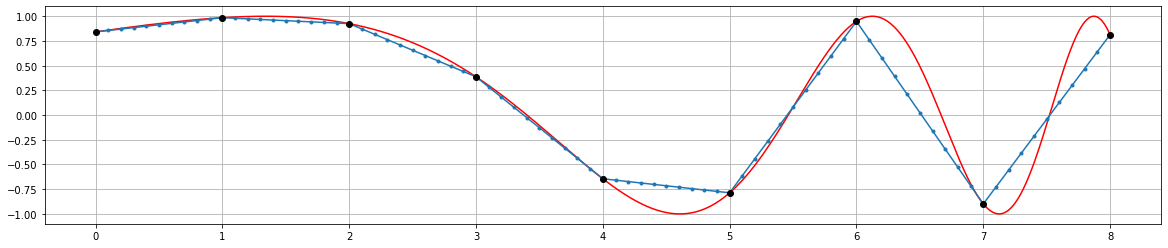

In [147]:
# My scalar function to interpolate
def f(x):
    return np.sin(1.4**x).sum()

J = (10,)  # number of grid points in each dimension
n = len(J) # dimension
xmax = J[0] - 2

Zj = [np.arange(J[j]) for j in range(n)] # integers points of each dimension
grid_in_Zn = product(*Zj) # grid: "rectangular" subset of Z^n. Cartesian product done via itertool.product

S = np.zeros(J)
for z in grid_in_Zn:
    S[z] = f(np.array(z))

M = 1 + (J[0] - 2) * 10
x = np.linspace(0, xmax, M).reshape((M, 1))
fx, fhatx = np.zeros(M), np.zeros(M)

for m in range(M):
    fx[m] = f(x[m])
    fhatx[m] = fhat(x[m])


import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))

xf = np.linspace(0, J[0] - 2, 1000)
plt.plot(xf, [f(xx) for xx in xf], 'r-')

plt.plot(x, fhatx, '.-')

zticks = range(0, J[0] - 1)
plt.plot(zticks, [f(z) for z in zticks], 'ko')

plt.grid()